### Amazon KNN Prodcut Recommender System

Goals: 
    
    1. Build a KNN recommender system using Amazon's Home and Kitchen reviews dataset 
    2. Analyzing the performance metrics of the above recommender system

The motivation behind taking up this project is that I use Amazon everyday and I really like their recommender system. They are very good at recommending prodcuts which I want to buy next. So, I don't have to spend much time to dig deeper and findout what I want. So, I decided to build a recommender system that can help recommend the nearest three to five prodcuts using prodcut reviews and ratings dataset.

#### Step1: Importing Required packages and loading required dataset

In [4]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn import neighbors
import matplotlib.pyplot as plt

% matplotlib inline

I have used 5-core Home and Kitchen reviews dataset. It is subset of the data in which all users and items have at least 5 reviews.

In [5]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Home_and_Kitchen_5.json.gz')

I would like to see the top five rows of dataset.

In [6]:
df.head(5).T

,0,1,2,3,4
reviewerID,APYOBQE6M18AA,A1JVQTAGHYOL7F,A3UPYGJKZ0XTU4,A2MHCTX43MIMDZ,AHAI85T5C2DH3
asin,0615391206,0615391206,0615391206,0615391206,0615391206
reviewerName,Martin Schwartz,Michelle Dinh,mirasreviews,"M. Johnson ""Tea Lover""",PugLover
helpful,"[0, 0]","[0, 0]","[26, 27]","[14, 18]","[0, 0]"
reviewText,My daughter wanted this book and the price on ...,I bought this zoku quick pop for my daughterr ...,There is no shortage of pop recipes available ...,This book is a must have if you get a Zoku (wh...,This cookbook is great. I have really enjoyed...
overall,5,5,4,5,4
summary,Best Price,zoku,"Excels at Sweet Dessert Pops, but Falls Short ...",Creative Combos,A must own if you own the Zoku maker...
unixReviewTime,1382140800,1403049600,1367712000,1312416000,1402099200
reviewTime,"10 19, 2013","06 18, 2014","05 5, 2013","08 4, 2011","06 7, 2014"


The above dataset has 9 variables. Those are 

reviewerID: ID of the reviewer 

asin: ID of the product  

reviewerName: Name of the reviewer 

helpful: helpfulness rating of the reviewer, e.g: 2/3 

reviewText: text of the review 

overall: rating of the product 

summary: summary of the review 

unixReviewTime: time of the review (unix time) 

reviewTime: time of the review (raw)


In [7]:
df.shape

(551682, 9)

From the above we can say that the dataset has 551682 rows and 9 columns of information.

#### Step2: Preparing data for KNN modeling

In [8]:
# Make new two columns out of 'helpful' column
df[['helpfulfirstelement', 'helpfulsecondelement']] = pd.DataFrame(df.helpful.values.tolist(), index = df.index)

In [9]:
df.drop('helpful', axis = 1, inplace = True)

In [10]:
df.shape

(551682, 10)

I take the prodcuts with more than 100 product reviews for further analysis and modeling.

In [11]:
reviews_count = df.groupby('asin').count().reset_index()

In [12]:
reviews_count.head(5).T

,0,1,2,3,4
asin,0615391206,0689027818,0912696591,1223070743,1567120709
reviewerID,11,5,93,8,16
reviewerName,11,5,93,8,16
reviewText,11,5,93,8,16
overall,11,5,93,8,16
summary,11,5,93,8,16
unixReviewTime,11,5,93,8,16
reviewTime,11,5,93,8,16
helpfulfirstelement,11,5,93,8,16
helpfulsecondelement,11,5,93,8,16


In [13]:
df_merged = pd.merge(df, reviews_count, on = 'asin', how = 'right')

In [14]:
df_merged.rename(columns={'reviewerID_y':'reviews_count', 'overall_x':'overall_review', 'summary_x':'summary_review'}, inplace=True)

In [15]:
df_final = df_merged[['asin', 'summary_review', 'overall_review', 'reviews_count']]

In [16]:
df_merged = df_merged.sort_values(by = 'reviews_count', ascending = False)

In [17]:
# selecting products with more than 50 reviews
df_count = df_merged[df_merged.reviews_count > 50]

In [18]:
df_count.shape

(211402, 19)

In [19]:
df_review_mean = df.groupby('asin').mean().reset_index()

In [20]:
df_review_mean.head(5)

,asin,overall,unixReviewTime,helpfulfirstelement,helpfulsecondelement
0,0615391206,4.454545,1.364429e+09,8.181818,9.363636
1,0689027818,5.000000,1.216253e+09,3.600000,3.800000
2,0912696591,4.548387,1.346279e+09,1.688172,1.817204
3,1223070743,4.250000,1.375024e+09,0.000000,0.000000
4,1567120709,4.062500,1.324523e+09,2.250000,2.562500


In [21]:
df_summary_review = pd.DataFrame(df_count.groupby('asin')['summary_review'].apply(list).reset_index())

In [22]:
df_summary_review.head(5)

,asin,summary_review
0,0912696591,"[Good refresher, great book for beginners, Nee..."
1,B00000JGRP,"[Mighty Mouse, Always have been happy with it ..."
2,B00000JGRT,"[cute and easy!, Paddle broke within 2 months,..."
3,B00002N5Z9,"[Too big, loud, powerful, lets bugs through fo..."
4,B00002N602,"[My Pot, Pressure Cooker, Great product, Very ..."


In [23]:
df_model = pd.merge(df_summary_review, df_review_mean, on = 'asin', how = 'inner')

In [24]:
df_model_data = df_model[['asin', 'summary_review', 'overall']]

In [25]:
df_model_data.head(5)

,asin,summary_review,overall
0,0912696591,"[Good refresher, great book for beginners, Nee...",4.548387
1,B00000JGRP,"[Mighty Mouse, Always have been happy with it ...",3.948052
2,B00000JGRT,"[cute and easy!, Paddle broke within 2 months,...",4.473934
3,B00002N5Z9,"[Too big, loud, powerful, lets bugs through fo...",4.176471
4,B00002N602,"[My Pot, Pressure Cooker, Great product, Very ...",4.563107


##### Text processing for modeling:

In [26]:
def text_process(text):
    text = text.lower()
    text = re.sub('[^a-z]+', ' ', text).strip()
    return text

In [27]:
df_model_data['clean_summary_review'] = df_model_data['summary_review'].apply(' '.join).apply(lambda x: text_process(x)).copy(deep=True)

/Users/kkgollu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
df_model_data['clean_summary_review'].head(5)

0    good refresher great book for beginners needed...
1    mighty mouse always have been happy with it wa...
2    cute and easy paddle broke within months omg t...
3    too big loud powerful lets bugs through for my...
4    my pot pressure cooker great product very good...
Name: clean_summary_review, dtype: object

In [31]:
df_model_data.drop_duplicates(['overall'], keep ='last', inplace = True)

In [32]:
df_model_data = df_model_data.reset_index()

#### TFIDF model feature extraction from clean_summary_review column:

In [33]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features = 500)
X = tfidf.fit_transform(df_model_data['clean_summary_review'])

Splitting X into train and test datasets. 

In [34]:
X_reviews = pd.DataFrame(X.A, columns = tfidf.get_feature_names()).astype(int)

In [35]:
X_reviews_array = np.array(X_reviews)

In [36]:
split_percent = 0.8
split_size = np.floor(split_percent * X_reviews.shape[0]).astype(int)

In [37]:
X_train = X_reviews_array[:split_size]
X_test = X_reviews_array[split_size:]

#### Applying KNN model to find out three nearest prodcuts:

To find the three nearest neighbors, I am going to use NearestNeighbors algorithm. 

In [38]:
nearest_neighbors = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X_train)

In [39]:
dist, index = nearest_neighbors.kneighbors(X_train)

Let's pull the three nearest neighbors using the above results.

In [40]:
for i in range(0, X_test.shape[0]):
    test_neighbors = nearest_neighbors.kneighbors([X_test[i]])
    related_product_indices = test_neighbors[1]
    first_nearest_product = [prod[0] for prod in related_product_indices]
    first_nearest_product = str(first_nearest_product).strip('[]')
    first_nearest_product = int(first_nearest_product)
    second_nearest_product = [prod[1] for prod in related_product_indices]
    second_nearest_product = str(second_nearest_product).strip('[]')
    second_nearest_product = int(second_nearest_product)
    third_nearest_product = [prod[2] for prod in related_product_indices]
    third_nearest_product = str(third_nearest_product).strip('[]')
    third_nearest_product = int(third_nearest_product)
    
    try:
        if i<4:
            print('Based on product reviews of ', df_model_data['asin'][X_train.shape[0] + i], ' the average rating is ', 
          df_model_data['overall'][X_train.shape[0] + i])
            print('The 1st recommended product is ', df_model_data['asin'][first_nearest_product], ' the average rating is ',
         df_model_data['overall'][first_nearest_product])
            print('The 2nd recommended product is ', df_model_data['asin'][second_nearest_product], ' the average rating is ',
         df_model_data['overall'][second_nearest_product])
            print('The 3rd recommended product is ', df_model_data['asin'][third_nearest_product], ' the average rating is ',
         df_model_data['overall'][third_nearest_product])
            print('-------------------------------------------------------------------------------------------')
    except:
        pass

Based on product reviews of  B005SI8YZC  the average rating is  3.8656716417910446
The 1st recommended product is  B0009NZ6JS  the average rating is  4.587301587301587
The 2nd recommended product is  B00004X13D  the average rating is  4.482558139534884
The 3rd recommended product is  B0000950Q4  the average rating is  3.9130434782608696
-------------------------------------------------------------------------------------------
Based on product reviews of  B005SPEV66  the average rating is  4.322033898305085
The 1st recommended product is  B0009NZ6JS  the average rating is  4.587301587301587
The 2nd recommended product is  B00004X13D  the average rating is  4.482558139534884
The 3rd recommended product is  B0000950Q4  the average rating is  3.9130434782608696
-------------------------------------------------------------------------------------------
Based on product reviews of  B005TOVVSC  the average rating is  4.516666666666667
The 1st recommended product is  B0009NZ6JS  the average r

#### Predictive Modeling: Let's use KNerighborsClassifier to classify: Prdicting overall review based on product reviews:

Let's define the target variable for predictive modeling

In [41]:
y_train = df_model_data['overall'][:X_train.shape[0]].astype(int)
y_test = df_model_data['overall'][X_train.shape[0]:].astype(int)

In [42]:
knnclassifier = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
knnclassifier.fit(X_train, y_train)
knnclassifier_predictions = knnclassifier.predict(X_test)

In [43]:
print(accuracy_score(y_test, knnclassifier_predictions))
print(mean_squared_error(y_test, knnclassifier_predictions))
#print(classification_report(y_test, knnclassifier_predictions))
#print(f1_score(y_test, knnclassifier_predictions, average='weighted'))

0.8949044585987261
0.10509554140127389


#### Word Clouding for each review group: 

In [44]:
review_text_for_overall = df.groupby('overall')['summary'].apply(list).reset_index()

In [45]:
review_text_for_overall

,overall,summary
0,1.0,"[Waste of money, Sprelling Only, It doesn't do..."
1,2.0,[Okay but you can figure it out yourself witho...
2,3.0,"[Good for what it's worth, Okay, Disappointed ..."
3,4.0,"[Excels at Sweet Dessert Pops, but Falls Short..."
4,5.0,"[Best Price, zoku, Creative Combos, Love it, B..."


In [46]:
review_text_for_overall['clean_summary'] = review_text_for_overall['summary'].apply(' '.join).apply(lambda x: text_process(x))

In [47]:
review_text_for_overall

,overall,summary,clean_summary
0,1.0,"[Waste of money, Sprelling Only, It doesn't do...",waste of money sprelling only it doesn t do mu...
1,2.0,[Okay but you can figure it out yourself witho...,okay but you can figure it out yourself withou...
2,3.0,"[Good for what it's worth, Okay, Disappointed ...",good for what it s worth okay disappointed aga...
3,4.0,"[Excels at Sweet Dessert Pops, but Falls Short...",excels at sweet dessert pops but falls short o...
4,5.0,"[Best Price, zoku, Creative Combos, Love it, B...",best price zoku creative combos love it beauti...


##### Write a function to draw wordcloud for each overall rating group:

In [48]:

stop_words = set(STOPWORDS)

def wordcloud_plot(txt_dat, title = None):
    wordcloud = WordCloud(background_color='white', stopwords=stop_words, max_words=300, max_font_size=30, 
        scale=3, random_state=1).generate(str(txt_dat))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

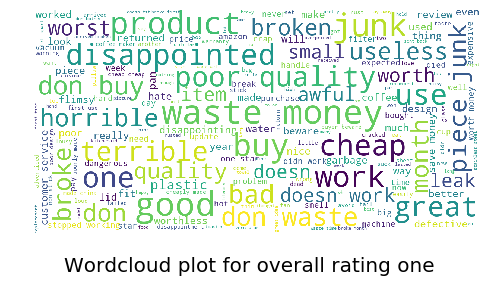

In [49]:
wordcloud_plot(review_text_for_overall['clean_summary'][0], title = 'Wordcloud plot for overall rating one')

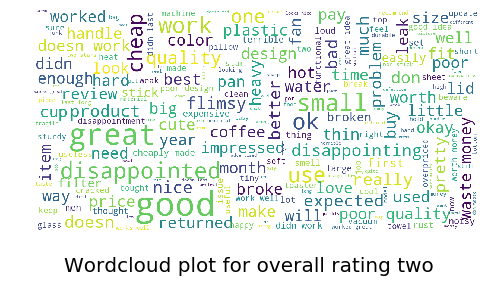

In [50]:
wordcloud_plot(review_text_for_overall['clean_summary'][1], title = 'Wordcloud plot for overall rating two')

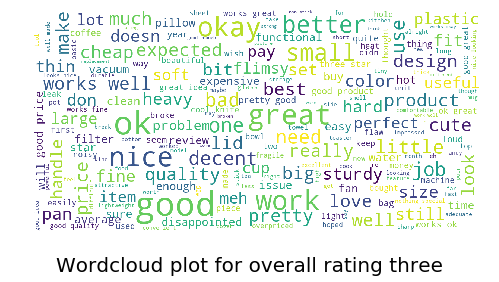

In [51]:
wordcloud_plot(review_text_for_overall['clean_summary'][2], title = 'Wordcloud plot for overall rating three')

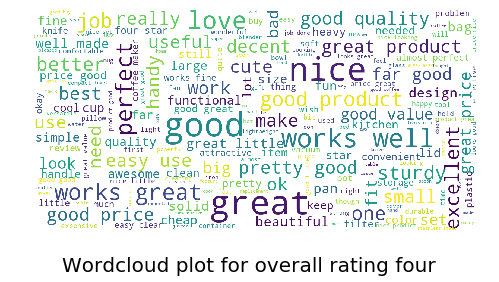

In [52]:
wordcloud_plot(review_text_for_overall['clean_summary'][3], title = 'Wordcloud plot for overall rating four')

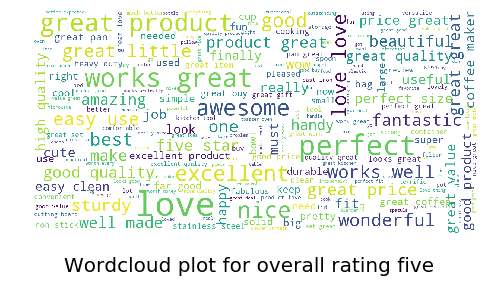

In [53]:
wordcloud_plot(review_text_for_overall['clean_summary'][4], title = 'Wordcloud plot for overall rating five')